In [1]:
import geopandas as gpd
import pandas as pd
import requests
from shapely.geometry import shape

In [2]:
results = pd.read_csv("combined_results.csv")

In [3]:
precincts = gpd.read_file("../../data/precincts24g.zip")

In [4]:
# Loading council districts geometry
council_districts_url = "https://services.arcgis.com/0L95CJ0VTaxqcmED/arcgis/rest/services/BOUNDARIES_single_member_districts/FeatureServer/0/query?where=1%3D1&outFields=*&returnGeometry=true&f=pgeojson"
response = requests.get(council_districts_url)
agol_data = response.json()
council_districts = []

for district in agol_data["features"]:
    row = district["properties"]
    row["geometry"] = shape(district["geometry"])
    council_districts.append(row)
council_districts = gpd.GeoDataFrame(council_districts, geometry="geometry", crs="EPSG:4326")

In [5]:
# Transforming the two geometry layers to the same coordinate reference system
council_districts = council_districts.to_crs(precincts.crs)

In [6]:
# Limiting to just Hays, Travis, Williamson
precincts = precincts[precincts["CNTY"].isin(list(results["County fips"].unique()))]

In [7]:
# Trimming election precincts to COA council districts
trimmed_precincts = gpd.overlay(precincts, council_districts, how='intersection')

In [8]:
# Building Key to merge precincts data to the results
results["PCTKEY"] = results["County fips"].astype(str) + results["Precinct"].astype(str).str.zfill(4)
# Merge geometry to the results
results = trimmed_precincts.merge(results, on="PCTKEY", how="left")

In [9]:
def produce_district_results(df, district, key):
    if district != "Mayor":
        df = df[df["COUNCIL_DISTRICT"]==district]
    candidates = []
    for col in df.columns:
        if col.startswith(key):
            candidates.append(col)
    
    df["winner"] = df[candidates].idxmax(axis=1, skipna=True)
    precincts_won = {}
    for candidate in candidates:
        won = df[df["winner"] == candidate]
        if not won.empty:
            won["winner pct"] = won[candidate]/won[candidates].sum(axis=1)
            precincts_won[candidate[len(key):]] = won
    return precincts_won
        

In [10]:
d2 = produce_district_results(results, 2, "D2-")
d4 = produce_district_results(results, 4, "D4-")
d6 = produce_district_results(results, 6, "D6-")
d7 = produce_district_results(results, 7, "D7-")
d10 = produce_district_results(results, 10, "D10-")
mayor = produce_district_results(results, "Mayor", "Mayor-")

/var/folders/ym/cg59ddhx7jl408c4hs61x_wm0000gp/T/ipykernel_37925/336302801.py:9: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df["winner"] = df[candidates].idxmax(axis=1, skipna=True)
/Users/charliehenry/anaconda3/envs/geo/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/charliehenry/anaconda3/envs/geo/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [11]:
import matplotlib.pyplot as plt
import random

def produce_district_map(precincts_won, precincts, name, filename):
    colors = ["Greens", "Oranges", "Purples"]
    
    # ideally don't want to use red/blue
    backup_colors = ["Blues", "Reds"]
    candidates = precincts_won.keys()
    ax = precincts.plot(column=None,color="grey", figsize=(8, 14), legend_kwds={"fmt":".0%"}, vmin=0, vmax=1, linewidth=0)
    for candidate in candidates:
        if colors:
            # select random color
            random_index = random.randint(0, len(colors) - 1)
            popped_color = colors.pop(random_index)
        else:
            # select random color
            random_index = random.randint(0, len(backup_colors) - 1)
            popped_color = backup_colors.pop(random_index)
        winner_data = precincts_won[candidate]
        # winner_data = winner_data["winner pct"].notna()
        winner_data.plot(ax=ax, column="winner pct", cmap=popped_color, legend=True, vmin=0, vmax=1, legend_kwds={"label":candidate, "orientation": "horizontal", "pad":-0.03, 'fmt': "{:.0%}"})
    ax.set_axis_off()
    ax.set_title(f"2024 City of Austin Elections: {name}")
    plt.savefig(f"{filename}.png", dpi=800)


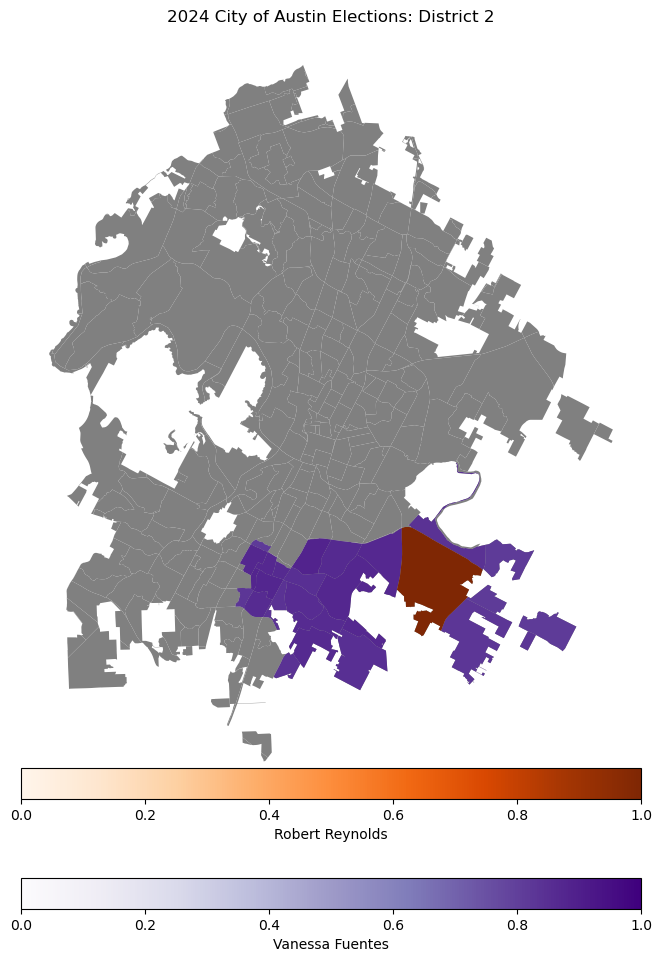

In [12]:
produce_district_map(d2, trimmed_precincts, "District 2", "d2")

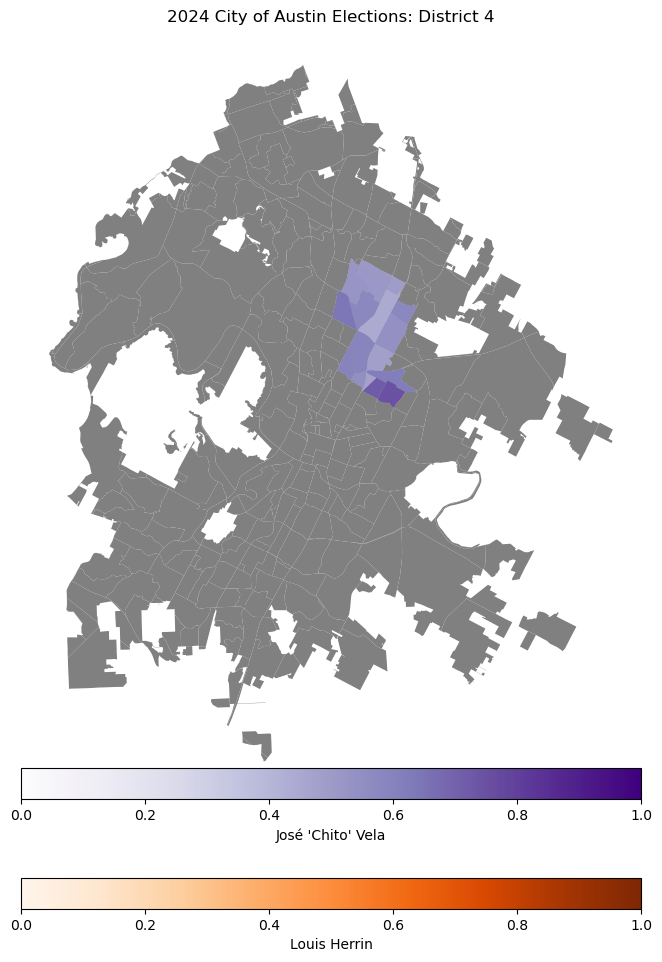

In [13]:
produce_district_map(d4, trimmed_precincts, "District 4", "d4")

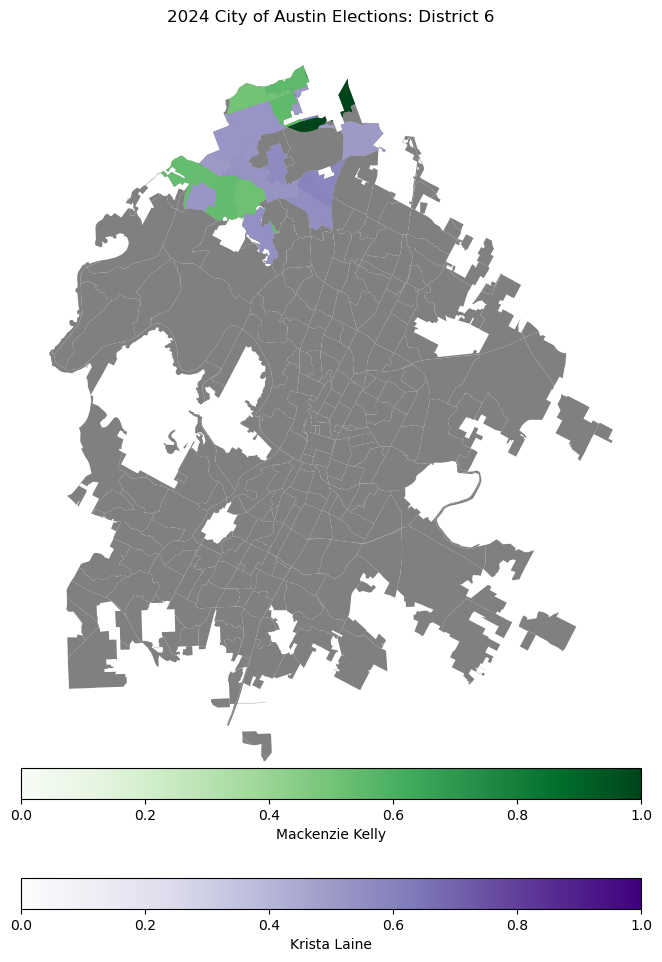

In [14]:
produce_district_map(d6, trimmed_precincts, "District 6", "d6")

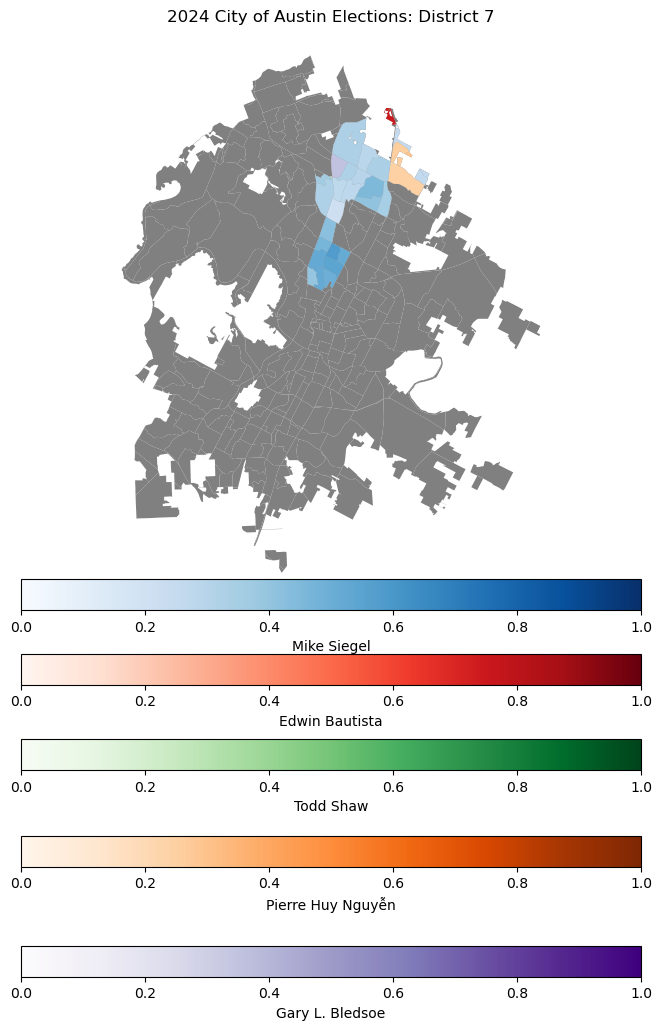

In [15]:
produce_district_map(d7, trimmed_precincts, "District 7", "d7")

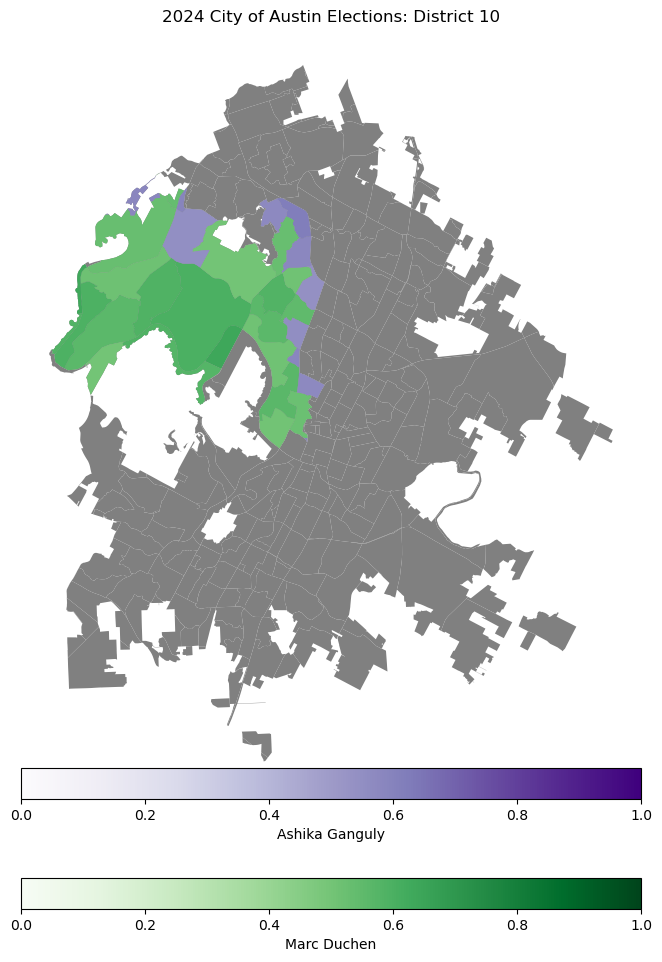

In [16]:
produce_district_map(d10, trimmed_precincts, "District 10", "d10")

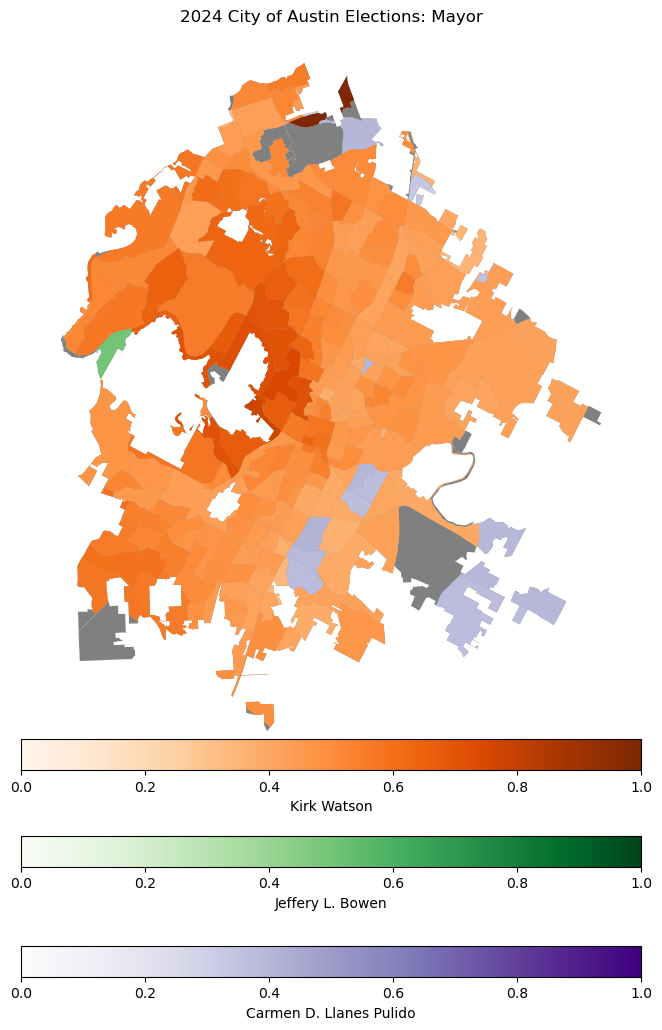

In [17]:
produce_district_map(mayor, trimmed_precincts, "Mayor", "mayor")